In [1]:
#imports libraries
import pandas as pd
import numpy as np
from sklearn import metrics
import seaborn as sns
from datetime import timedelta
from datetime import datetime
import matplotlib.pyplot as plt

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

#imports for acquire and prep
from env import get_db_url
import os
import acquire
import wrangle

# Team Anomaly Detection Project:

This repo is my side of the exploration, in first, answering question #3, and then using our Team's wrangle.py file to do more exploring on finding other anomalies and/or takeaways that might have been overlooked and added to the Codeup email.

#### Pulling in the wrangle dataframe with the acquire file, and then doing simple changes to further the process of answering questions 3.

In [2]:
#calling in acquire function for OG dataset (minimized cleaning/wrangle)
df, df_staff, df_multicohort, df_unimputed, df_non_curriculum, df_outliers=wrangle.full_wrangle()

This returned the following dataframes (reassign if you missed any):


,Description,Record Count,Percent of Raw df
Dataframe,,,
df,Fully cleaned dataframe,509409,56.6%
df_staff,Cohort == Staff,84031,9.33%
df_multicohort,Users listed in more than one cohort,22708,2.52%
df_unimputed,Users with unknown/unimputable cohorts,45904,5.1%
df_non_curriculum,"Accessess not related to the curriculum, i.e. directories, images",116539,12.9%
df_outliers,Accesses meeting outlier conditions,121626,13.5%


#### Looking at all of the dataframes:

In [3]:
#looking at df:
df.head(2)

,accessed,path,ip,user_id,program_id,program_type,cohort,start_date,end_date,lesson,hour
1,2018-01-26 09:56:02,java-ii,97.105.19.61,1,1.0,Web Development,Hampton,2015-09-22,2016-02-06,Not Lesson,9
2,2018-01-26 09:56:05,java-ii/object-oriented-programming,97.105.19.61,1,1.0,Web Development,Hampton,2015-09-22,2016-02-06,java-ii.object-oriented-programming,9


In [4]:
#looking at outlier datasets: df_staff (only holds Staff members and their info)
df_staff.head(2)

,accessed,path,ip,user_id,program_id,program_type,cohort,start_date,end_date,lesson,hour
166284,2018-12-06 14:15:29,appendix/further-reading/java/intellij-tomcat-configuration,97.105.19.58,53,2.0,Web Development,Staff,2014-02-04,2014-02-04,Not Lesson,14
166294,2018-12-06 14:25:40,javascript-i,97.105.19.58,314,2.0,Web Development,Staff,2014-02-04,2014-02-04,Not Lesson,14


In [5]:
#looking at outlier datasets: df_multicohort (only holds outliers that have multicohorts in data)
df_multicohort.head(2)

,accessed,path,ip,user_id,program_id,program_type,cohort,start_date,end_date,lesson,hour
111,2018-01-26 11:36:00,mkdocs/search_index.json,97.105.19.61,25,2.0,Web Development,Teddy,2018-01-08,2018-05-17,mkdocs.search_index.json,11
124,2018-01-26 11:41:09,javascript-i/functions,97.105.19.61,25,2.0,Web Development,Teddy,2018-01-08,2018-05-17,javascript-i.functions,11


In [6]:
#looking at outlier datasets: df_unimputed (only holds df w/o imputes)
df_unimputed.head(2)

,accessed,path,ip,user_id,program_id,program_type,cohort,start_date,end_date,lesson,hour
965,2018-01-28 23:42:55,/,24.160.159.122,54,NaN,Web Development,NaN,NaT,NaT,.,23
966,2018-01-28 23:43:12,spring/extra-features,24.160.159.122,54,NaN,Web Development,NaN,NaT,NaT,spring.extra-features,23


In [7]:
#looking at outlier datasets: df_non_curriculum (only holds outliers with no lessons)
df_non_curriculum.head(2)

,accessed,path,ip,user_id,program_id,program_type,cohort,start_date,end_date,lesson,hour
0,2018-01-26 09:55:03,/,97.105.19.61,1,1.0,Web Development,Hampton,2015-09-22,2016-02-06,.,9
12,2018-01-26 10:00:37,/,97.105.19.61,6,2.0,Web Development,Teddy,2018-01-08,2018-05-17,.,10


In [8]:
#looking at outlier datasets: df_outliers (only holds datasets that were seen as outliers)
df_outliers.head(2)

,accessed,path,ip,user_id,program_id,program_type,cohort,start_date,end_date,lesson,hour
6,2018-01-26 09:56:46,javascript-i/conditionals,97.105.19.61,3,2.0,Web Development,Teddy,2018-01-08,2018-05-17,javascript-i.conditionals,9
7,2018-01-26 09:56:48,javascript-i/functions,97.105.19.61,3,2.0,Web Development,Teddy,2018-01-08,2018-05-17,javascript-i.functions,9


Creating a column to show True or False if accessed data is during the user's cohort dates (accessed when active).

In [9]:
df['is_active'] = (df.accessed >= df.start_date) & (df.accessed <= df.end_date)
df.head(2)

,accessed,path,ip,user_id,program_id,program_type,cohort,start_date,end_date,lesson,hour,is_active
1,2018-01-26 09:56:02,java-ii,97.105.19.61,1,1.0,Web Development,Hampton,2015-09-22,2016-02-06,Not Lesson,9,False
2,2018-01-26 09:56:05,java-ii/object-oriented-programming,97.105.19.61,1,1.0,Web Development,Hampton,2015-09-22,2016-02-06,java-ii.object-oriented-programming,9,False


#### Sorting WebDev and DS into different objects to explore:

In [10]:
#splitting webdev and datascience into two different df:
wd = df[df.program_type != 'Data Science']
ds = df[df.program_type == 'Data Science']

In [11]:
df.dtypes

accessed        datetime64[ns]
path                    object
ip                      object
user_id                  int64
program_id             float64
program_type            object
cohort                  object
start_date      datetime64[ns]
end_date        datetime64[ns]
lesson                  object
hour                     int64
is_active                 bool
dtype: object

#### Showing students that were actively accessing the curriculum during their cohort dates:

In [13]:
#splitting cohorts into program types:
#Ray's code to filter dataframe for time where students are active during their programs
# Filter dataframe for the time when student were 'active' for each program
active_wd = wd.loc[(wd.accessed >= wd.start_date) & (wd.accessed <= wd.end_date)]
active_ds = ds.loc[(ds.accessed >= ds.start_date) & (ds.accessed <= ds.end_date)]

In [14]:
#number of active wb students compared to ds students:
print(f'Number of active WebDev students during their cohort dates:', active_wd.value_counts().sum())
print(f'Number of active DataScience students during their cohort dates:', active_ds.value_counts().sum())

Number of active WebDev students during their cohort dates: 385855
Number of active DataScience students during their cohort dates: 51665


In [15]:
#creating a function to run other dfs through, to check what active ds students are missing...
#def lost_ds(df):
    #wd = df[df.program_type != 'Data Science']
    #ds = df[df.program_type == 'Data Science']
    #active_wd = wd.loc[(wd.index >= wd.start_date) & (wd.index <= wd.end_date)]
    #active_ds = ds.loc[(ds.index >= ds.start_date) & (ds.index <= ds.end_date)]
    #number of active wb students compared to ds students:
    #print(f'Number of active WebDev students during their cohort dates:', active_wd.value_counts().sum())
    #print(f'Number of active DataScience students during their cohort dates:', active_ds.value_counts().sum())

__________________________________________

### 3. Are there students who, when active, hardly access the curriculum? If so, what information do you have about these students?
Active students that do not engage with curriculum?

user_id frequency counts
current dates of cohorts
ip addresses?

### Active Students with low curriculum access during each program:

#### WEB DEV:

In [16]:
#webdev students with lowest log access count:
hardly_access_wd = active_wd.groupby('user_id').size().sort_values().head(20)
hardly_access_wd

user_id
278     3
340    13
963    15
41     22
371    24
529    29
967    30
978    32
36     36
57     42
543    43
56     44
45     51
46     51
975    59
969    60
65     63
33     63
250    63
253    71
dtype: int64

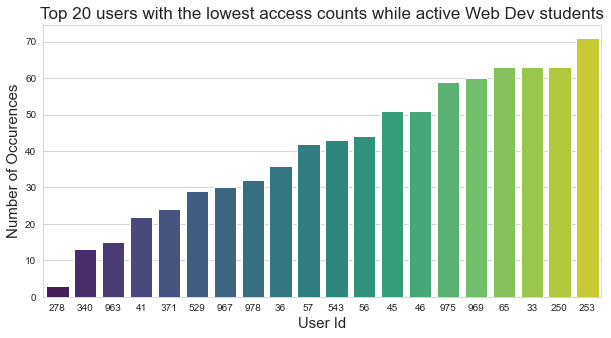

In [84]:
#histogram of these users under 20 logged access dates:
user_id_count = active_wd.groupby('user_id').size().sort_values()
user_id_count = user_id_count[:20]
plt.figure(figsize=(10,5))
sns.barplot(user_id_count.index, user_id_count.values, order=hardly_access_wd.index, palette="viridis")
plt.title ('Top 20 users with the lowest access counts while active Web Dev students', fontsize=17)
plt.ylabel('Number of Occurences', fontsize=15)
plt.xlabel('User Id', fontsize=15)
plt.show()

# Data Science:

In [18]:
#looking at ds active students that had lowest curriculum log access counts
hardly_access_ds = active_ds.groupby('user_id').size().sort_values().head(20)
hardly_access_ds

user_id
902    118
780    145
577    190
901    201
683    205
914    235
897    241
949    288
846    288
910    313
477    327
907    328
693    345
896    354
575    355
583    356
470    365
587    372
908    386
616    401
dtype: int64

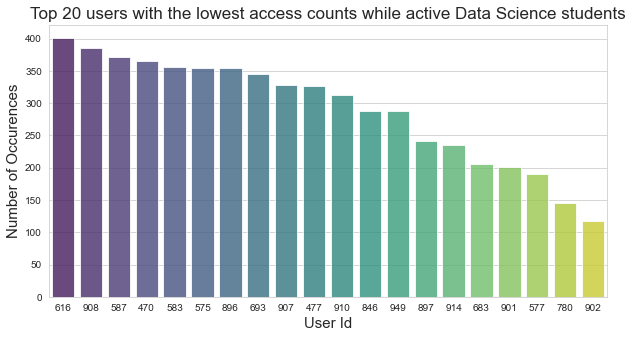

In [83]:
#histogram of these 3 users under 114 access logs on curriculum:
user_id_count1 = active_ds.groupby('user_id').size().nsmallest(20)
user_id_count1 = user_id_count1[:20]
my_order = list(hardly_access_ds.index)
my_order.reverse()
plt.figure(figsize=(10,5))
sns.barplot(user_id_count1.index, user_id_count1.values, alpha=0.8, order=my_order, palette="viridis")
plt.title ('Top 20 users with the lowest access counts while active Data Science students', fontsize=17)
plt.ylabel('Number of Occurences', fontsize=15)
plt.xlabel('User Id', fontsize=15)
plt.show()

#### Putting cohorts side-by-side:

In [85]:
import math
def activeuser_stacked_plot(columns_to_plot, title, df):
    
    '''
    Returns a 100% stacked plot of the response variable for independent variable of the list columns_to_plot.
    Parameters: columns_to_plot (list of string): Names of the variables to plot
    '''
    
    number_of_columns = 2
    number_of_rows = math.ceil(len(columns_to_plot)/2)

    # create a figure
    fig = plt.figure(figsize=(12, 5 * number_of_rows)) 
    fig.suptitle(title, fontsize=22,  y=.95)
 

    # loop to each column name to create a subplot
    for index, column in enumerate(columns_to_plot, 1):

        # create the subplot
        ax = fig.add_subplot(number_of_rows, number_of_columns, index)

        # calculate the percentage of observations of the response variable for each group of the independent variable
        # 100% stacked bar plot
        prop_by_independent = pd.crosstab(df[column], df['is_active']).apply(lambda x: x/x.sum()*100, axis=1)

        prop_by_independent.plot(kind='bar', ax=ax, stacked=True,
                                 rot=0, color=['#608C9B','#ebb086'])

        # set the legend in the upper right corner
        ax.legend(loc="upper right", bbox_to_anchor=(0.62, 0.5, 0.5, 0.5),
                  title='is_active', fancybox=True)

        # eliminate the frame from the plot
        spine_names = ('top', 'right', 'bottom', 'left')
        for spine_name in spine_names:
            ax.spines[spine_name].set_visible(False)

    return activeuser_stacked_plot


<function __main__.activeuser_stacked_plot(columns_to_plot, title, df)>

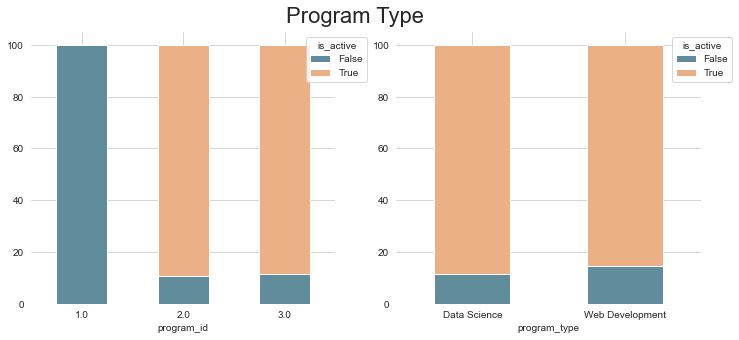

In [86]:
columns_to_plot = ['program_id','program_type']
activeuser_stacked_plot(columns_to_plot, 'Program Type', df)

Text(0.5, 1.0, 'Six month increments of non active users vs active users')

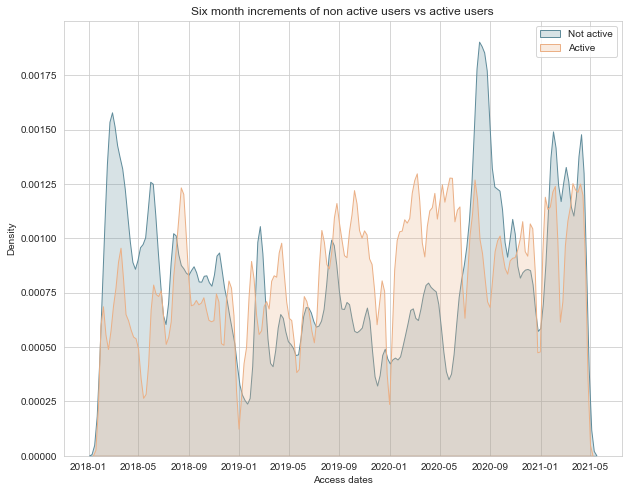

In [87]:
plt.figure(figsize=(10,8))
act = sns.kdeplot(df.accessed[(df['is_active'] == False) ],
                color='#608C9B', shade = True, bw_adjust=.2)
act = sns.kdeplot(df.accessed[(df['is_active'] == True) ],
                ax =act, color='#EBB086', shade= True, bw_adjust=.2)
act.legend(['Not active','Active'])
act.set_ylabel('Density')
act.set_xlabel('Access dates')
act.set_title('Six month increments of non active users vs active users')

Text(0, 0.5, 'Programs: 1-WebDev, 2-WebDev, 3-DataSc')

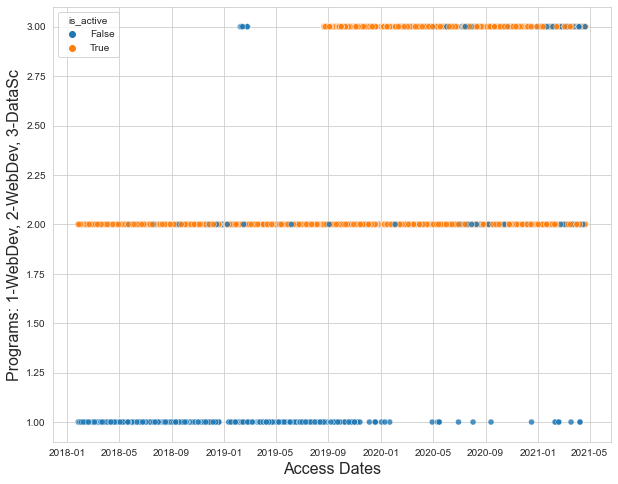

In [21]:
#sns.kdeplot(df.accessed, df.program_id, with hue of is_active or not)
sample = df.sample(20000)
plt.figure(figsize=(10,8))
sns.scatterplot(sample.accessed, sample.program_id, hue=sample.is_active, alpha=0.8)
plt.xlabel('Access Dates', fontsize=16)
plt.ylabel('Programs: 1-WebDev, 2-WebDev, 3-DataSc', fontsize=16)

_______________________________________________

## Answers to Questions:
#### Overall, DataScience students are accessing their curriculum's website more times than WebDev.
    - Do DS teachers teach more from the curriculum?
    - What do exercises in the curriculum and lessons look like for each program type?

## Takeaways and further Questions needed:

1) Was there another website with curriculum information that 2018 students had access to? (confirmed that Webdev program 1 students were using and had access to another curriculum prior to the accessed minimum date)

In [55]:
#minimum date students are accessing Codeup website:
df.index.min()

1

<b>Some of the students that have a 'low' access log count might actually also being using another curriculum, if there was one available.</b>

One example of this is student #278.

This WebDev student only had 3 showing log counts during their cohort's active period, however after the cohort this student made 60 more log counts after their end date.

One of two things:
- Students/Alumni's are utilizing curriculum (some more so) after graduating
- This could also be a web scrapping case!

#### Example of Webdev student that had only 3 active accessed logs, but then utilized the curriculm more so after cohort dates:

In [56]:
#lowest webdev student accessing curriculum was due to them using the curriculum more-so after cohort dates.
df[df.user_id == 278]

,accessed,path,ip,user_id,program_id,program_type,cohort,start_date,end_date,lesson,hour,is_active
121405,2018-09-27 14:47:37,java-ii/arrays,107.77.217.9,278,2.0,Web Development,Voyageurs,2018-05-29,2018-10-11,java-ii.arrays,14,True
121419,2018-09-27 14:58:48,java-ii/arrays,107.77.217.9,278,2.0,Web Development,Voyageurs,2018-05-29,2018-10-11,java-ii.arrays,14,True
121421,2018-09-27 14:59:07,java-ii/collections,107.77.217.9,278,2.0,Web Development,Voyageurs,2018-05-29,2018-10-11,java-ii.collections,14,True
130820,2018-10-16 18:56:02,javascript-ii,67.11.175.66,278,2.0,Web Development,Voyageurs,2018-05-29,2018-10-11,Not Lesson,18,False
130821,2018-10-16 18:56:22,javascript-ii/es6,67.11.175.66,278,2.0,Web Development,Voyageurs,2018-05-29,2018-10-11,javascript-ii.es6,18,False
...,...,...,...,...,...,...,...,...,...,...,...,...
179494,2019-02-09 17:31:50,mysql/introduction,67.11.175.66,278,2.0,Web Development,Voyageurs,2018-05-29,2018-10-11,mysql.introduction,17,False
179496,2019-02-09 17:35:43,mysql/tables,67.11.175.66,278,2.0,Web Development,Voyageurs,2018-05-29,2018-10-11,mysql.tables,17,False
179502,2019-02-09 17:37:19,mysql/basic-statements,67.11.175.66,278,2.0,Web Development,Voyageurs,2018-05-29,2018-10-11,mysql.basic-statements,17,False
179510,2019-02-09 17:58:08,mysql/tables,67.11.175.66,278,2.0,Web Development,Voyageurs,2018-05-29,2018-10-11,mysql.tables,17,False


#### Example of Webdev student that possibly dropped out of course after looking through materials...or possible dummy-account to check through student access to links?

In [57]:
#example of a possible web dev student that dropped out of course or maybe a dummy account that is checking on course links?
df[df.user_id == 340]

,accessed,path,ip,user_id,program_id,program_type,cohort,start_date,end_date,lesson,hour,is_active
168682,2019-01-22 16:49:49,html-css,97.105.19.58,340,2.0,Web Development,Zion,2019-01-22,2019-06-04,Not Lesson,16,True
168684,2019-01-22 16:50:48,html-css/introduction,97.105.19.58,340,2.0,Web Development,Zion,2019-01-22,2019-06-04,html-css.introduction,16,True
168685,2019-01-22 16:51:13,html-css/elements,97.105.19.58,340,2.0,Web Development,Zion,2019-01-22,2019-06-04,html-css.elements,16,True
168686,2019-01-22 16:51:18,javascript-i,97.105.19.58,340,2.0,Web Development,Zion,2019-01-22,2019-06-04,Not Lesson,16,True
168688,2019-01-22 16:51:32,html-css,97.105.19.58,340,2.0,Web Development,Zion,2019-01-22,2019-06-04,Not Lesson,16,True
168689,2019-01-22 16:51:36,html-css/introduction,97.105.19.58,340,2.0,Web Development,Zion,2019-01-22,2019-06-04,html-css.introduction,16,True
168690,2019-01-22 16:51:53,html-css/css-ii/media-queries,97.105.19.58,340,2.0,Web Development,Zion,2019-01-22,2019-06-04,html-css.css-ii.media-queries,16,True
168691,2019-01-22 16:52:22,html-css/css-ii/grids,97.105.19.58,340,2.0,Web Development,Zion,2019-01-22,2019-06-04,html-css.css-ii.grids,16,True
168693,2019-01-22 16:52:39,html-css/css-ii/bootstrap-introduction,97.105.19.58,340,2.0,Web Development,Zion,2019-01-22,2019-06-04,html-css.css-ii.bootstrap-introduction,16,True
168694,2019-01-22 16:52:59,html-css/css-ii/bootstrap-grid-system,97.105.19.58,340,2.0,Web Development,Zion,2019-01-22,2019-06-04,html-css.css-ii.bootstrap-grid-system,16,True


#### Example of DS student: student accessed data for 2 months and then stopped using curriculum (even before end_date). Possibly dropped out midway through course?

In [61]:
#lowest count of accessed logs for active DS student:
df[df.user_id == 902]

,accessed,path,ip,user_id,program_id,program_type,cohort,start_date,end_date,lesson,hour,is_active
703828,2021-03-16 11:54:40,fundamentals/intro-to-data-science,71.136.251.73,902,3.0,Data Science,Florence,2021-03-15,2021-09-03,fundamentals.intro-to-data-science,11,True
704227,2021-03-16 15:10:15,fundamentals/intro-to-data-science,71.136.251.73,902,3.0,Data Science,Florence,2021-03-15,2021-09-03,fundamentals.intro-to-data-science,15,True
704231,2021-03-16 15:11:04,fundamentals/intro-to-data-science,71.136.251.73,902,3.0,Data Science,Florence,2021-03-15,2021-09-03,fundamentals.intro-to-data-science,15,True
704256,2021-03-16 15:13:43,fundamentals/intro-to-data-science,71.136.251.73,902,3.0,Data Science,Florence,2021-03-15,2021-09-03,fundamentals.intro-to-data-science,15,True
704424,2021-03-16 15:40:55,fundamentals/intro-to-data-science,71.136.251.73,902,3.0,Data Science,Florence,2021-03-15,2021-09-03,fundamentals.intro-to-data-science,15,True
...,...,...,...,...,...,...,...,...,...,...,...,...
747160,2021-04-21 11:11:42,python/dataframes,71.136.251.73,902,3.0,Data Science,Florence,2021-03-15,2021-09-03,python.dataframes,11,True
747161,2021-04-21 11:12:29,python/dataframes,71.136.251.73,902,3.0,Data Science,Florence,2021-03-15,2021-09-03,python.dataframes,11,True
747162,2021-04-21 11:12:33,python/series,71.136.251.73,902,3.0,Data Science,Florence,2021-03-15,2021-09-03,python.series,11,True
747163,2021-04-21 11:12:51,python/dataframes,71.136.251.73,902,3.0,Data Science,Florence,2021-03-15,2021-09-03,python.dataframes,11,True


#### Example of a DS student having low curriculum accessed counts, but still using curriculum after end_date.

In [62]:
#lowest count of accessed logs for active DS student:
df[df.user_id == 780]

,accessed,path,ip,user_id,program_id,program_type,cohort,start_date,end_date,lesson,hour,is_active
593350,2020-10-22 14:21:19,timeseries/overview,99.132.128.255,780,3.0,Data Science,Darden,2020-07-13,2021-01-12,timeseries.overview,14,True
593523,2020-10-22 15:35:22,timeseries/acquire,99.132.128.255,780,3.0,Data Science,Darden,2020-07-13,2021-01-12,timeseries.acquire,15,True
593737,2020-10-22 18:40:09,regression/acquire-and-prep,99.132.128.255,780,3.0,Data Science,Darden,2020-07-13,2021-01-12,regression.acquire-and-prep,18,True
593738,2020-10-22 18:41:01,regression/split-and-scale,99.132.128.255,780,3.0,Data Science,Darden,2020-07-13,2021-01-12,regression.split-and-scale,18,True
593739,2020-10-22 18:42:11,regression/explore,99.132.128.255,780,3.0,Data Science,Darden,2020-07-13,2021-01-12,regression.explore,18,True
...,...,...,...,...,...,...,...,...,...,...,...,...
694354,2021-03-05 14:05:36,advanced-topics/intro-to-flask,91.132.138.164,780,3.0,Data Science,Darden,2020-07-13,2021-01-12,advanced-topics.intro-to-flask,14,False
694493,2021-03-05 15:47:43,nlp/acquire,91.132.138.164,780,3.0,Data Science,Darden,2020-07-13,2021-01-12,nlp.acquire,15,False
696675,2021-03-08 17:20:40,advanced-topics/virtual-environments,99.132.128.255,780,3.0,Data Science,Darden,2020-07-13,2021-01-12,advanced-topics.virtual-environments,17,False
708461,2021-03-19 03:24:27,nlp/acquire,99.132.128.255,780,3.0,Data Science,Darden,2020-07-13,2021-01-12,nlp.acquire,3,False


2) Does Codeup recycle their user_ids at all? -Answer was no, not likely.

_________________________________________________

#### User_id examples of users that went from student to staff

In [58]:
#who dis? 
df[df.user_id == 53]

,accessed,path,ip,user_id,program_id,program_type,cohort,start_date,end_date,lesson,hour,is_active
912,2018-01-28 18:48:19,index.html,67.10.161.55,53,1.0,Web Development,Lassen,2016-07-18,2016-11-10,Not Lesson,18,False
913,2018-01-28 18:48:24,html-css,67.10.161.55,53,1.0,Web Development,Lassen,2016-07-18,2016-11-10,Not Lesson,18,False
914,2018-01-28 18:49:20,javascript-i,67.10.161.55,53,1.0,Web Development,Lassen,2016-07-18,2016-11-10,Not Lesson,18,False
915,2018-01-28 18:49:23,javascript-i/conditionals,67.10.161.55,53,1.0,Web Development,Lassen,2016-07-18,2016-11-10,javascript-i.conditionals,18,False
916,2018-01-28 18:50:41,javascript-i/conditionals,67.10.161.55,53,1.0,Web Development,Lassen,2016-07-18,2016-11-10,javascript-i.conditionals,18,False
...,...,...,...,...,...,...,...,...,...,...,...,...
373753,2020-01-22 13:33:12,spring/fundamentals/form-model-binding,97.105.19.58,53,1.0,Web Development,Lassen,2016-07-18,2016-11-10,spring.fundamentals.form-model-binding,13,False
374743,2020-01-23 09:47:35,index.html,97.105.19.58,53,1.0,Web Development,Lassen,2016-07-18,2016-11-10,Not Lesson,9,False
374744,2020-01-23 09:47:41,java-ii,97.105.19.58,53,1.0,Web Development,Lassen,2016-07-18,2016-11-10,Not Lesson,9,False
374745,2020-01-23 09:47:42,java-ii/inheritance-and-polymorphism,97.105.19.58,53,1.0,Web Development,Lassen,2016-07-18,2016-11-10,java-ii.inheritance-and-polymorphism,9,False


In [60]:
#another student to staff:
df[df.user_id ==539]

,accessed,path,ip,user_id,program_id,program_type,cohort,start_date,end_date,lesson,hour,is_active


#### Why some students may have nulls:

In [59]:
#This last user_id had nulls. When following it, this shows that possible nulls might be when students are
#going through their prework phase at Codeup...good to know for another time...
df[df.user_id == 88]

,accessed,path,ip,user_id,program_id,program_type,cohort,start_date,end_date,lesson,hour,is_active


Looking at each of these students to learn more:

In [ ]:
#user 95 (wondering if this is a webscraper? start date and access dates do not make sense)
df[df.user_id == 95]

In [ ]:
#user 679: maybe they quit??
df[df.user_id == 679]

In [ ]:
#user 71 : access dates and start_date do not coincide..
df[df.user_id == 71]

In [ ]:
#user 246 : looks like webscaper | odd sign-in times and access/start dates do not match
df[df.user_id == 246]

In [ ]:
#user 399: pathways and quick scan times look like a webscraper
df[df.user_id == 399]

In [ ]:
#user 956: looks like a student that my have dropped out
df[df.user_id == 956]

In [ ]:
#user 539: student that dropped?
df[df.user_id == 539]

In [ ]:
#user 216: possible web scraper?
df[df.user_id == 216]

In [ ]:
#user 177: path would indicate web scrap (images and favicon only)
df[df.user_id == 177]

In [ ]:
#user 81: path would indicate web scrap (html and css only)
df[df.user_id == 81]

In [ ]:
#user 169: looks like web scraper
df[df.user_id == 169]

In [ ]:
#user 85: looks like a past possible student that dropped out or never started
df[df.user_id == 85]

In [ ]:
#user 832: student that didn't interact with curriculum??
df[df.user_id == 832]

In [ ]:
#user 97: web scraper
df[df.user_id == 97]

In [ ]:
#user 857: probably student that dropped out
df[df.user_id == 857]

In [ ]:
#user 348: probably web scraper
df[df.user_id == 348]

In [ ]:
#user 212: probably web scraper or maybe a past student?? (is there much info from 2014?)
df[df.user_id == 212]

In [ ]:
#user 593: probably web scraper 
df[df.user_id == 593]

In [ ]:
#user 165: probably web scraper 
df[df.user_id == 165]

#### Creating objects based on exploration of these students:

In [ ]:
#creating object of known dropped students:
df_drop_students = df[df.user_id == 85],df[df.user_id == 956]

In [ ]:
#info together:
df_drop_students

In [ ]:
#creating object of known web scrapers:
web_scrapes = df[df.user_id == 177],df[df.user_id == 399], df[df.user_id == 246]

In [ ]:
#creating object of possible web scrapers:
poss_web_scrapes = df[df.user_id == 165],df[df.user_id == 593], df[df.user_id == 212], df[df.user_id == 348], df[df.user_id == 857],df[df.user_id == 97], df[df.user_id == 832], df[df.user_id == 85], df[df.user_id == 169], df[df.user_id == 81],df[df.user_id == 216]

In [ ]:
#creating object of student then staff users:
student_staff = df[df.user_id == 539],df[df.user_id == 64]

In [ ]:
#reminding myself of column names:
df.columns

In [ ]:
#histograph of user_id counts
df.user_id.hist(figsize=(15, 10),
            ec='black',
            grid=True,
            bins=25);

In [ ]:
#sns is having issues with index as it is showing duplicates:
df.index.is_unique

In [ ]:
#dropping index duplicates
df=df.loc[~df.index.duplicated(), :]

#### Can we look at users' access log times? (help determine any web scrapers)

In [ ]:
#adding hour column to df for hours shown:
df['hour'] = pd.to_datetime(df.time).dt.hour
df.head(1)

In [ ]:
#showing hours these hardly accessed students logged in at:


In [ ]:
#user_id to cohort: are there student ranges here?
sns.histplot(data=df, x=df.user_id, hue=df.program_id, bins=30)

#### Question: Are there overlaps or recycling happening with user_id?

In [ ]:
#user_id to cohort: are there student ranges here?
sns.histplot(data=df, x=df.user_id, hue=df.program_id, bins=60, multiple="stack")

In [ ]:
plt.figure(figsize=(10,5))
sns.barplot(df.user_id.index, df.program_type.values, alpha=0.8)
plt.title ('Hardly Accessed Data Science Curriculum')
plt.ylabel('Number of Occurences')
plt.xlabel('User Id', fontsize=15)
plt.show()

In [ ]:
#user example of student then staff member
#df[df.user_id ==539]

In [ ]:
#using wrangle code to call in all dataframes and file to call in curriculum_log data:
df, df_staff, df_multicohort, df_unimputed, df_non_curriculum, df_outliers=wrangle.full_wrangle()